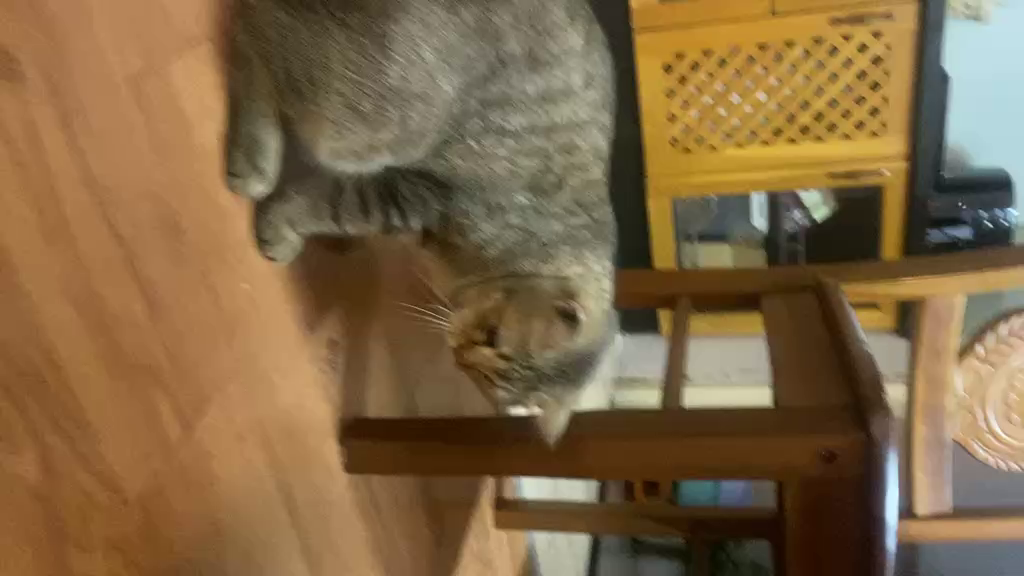

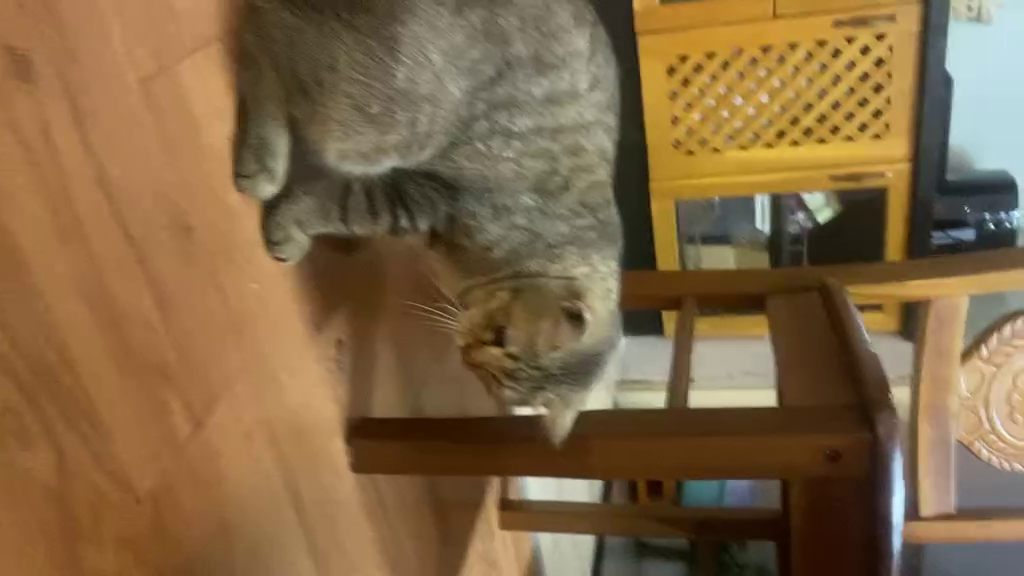

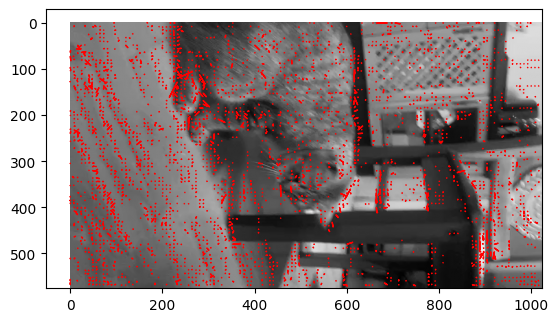

In [57]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
video_path = "/content/a22a42f2-6bd0-4f3b-b696-288610c0263a.mp4"
cap = cv2.VideoCapture(video_path)
ret1, frame1 = cap.read()
ret2, frame2 = cap.read()
cap.release()
cv2_imshow(frame1)
cv2_imshow(frame2)
beforeImage = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY).astype(np.float32)
afterImage = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY).astype(np.float32)
Ix = cv2.Sobel(beforeImage, cv2.CV_32F, 1, 0, ksize=3)
Iy = cv2.Sobel(beforeImage, cv2.CV_32F, 0, 1, ksize=3)
It = (afterImage - beforeImage) / 2
Ix = torch.tensor(Ix).unsqueeze(0).unsqueeze(0)
Iy = torch.tensor(Iy).unsqueeze(0).unsqueeze(0)
It = torch.tensor(It).unsqueeze(0).unsqueeze(0)
u = torch.zeros_like(Ix)
v = torch.zeros_like(Iy)
alpha = 15
lamda = 1
threshold = 1e-3
iter_counter = 0
kernel = torch.tensor([
    [0,  1/4,  0],
    [1/4, 0,  1/4],
    [0,  1/4,  0]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
while True:
    iter_counter += 1
    u_mean = F.conv2d(u, kernel, padding=1)
    v_mean = F.conv2d(v, kernel, padding=1)

    u_new = u_mean - (Ix * (Ix * u_mean + Iy * v_mean + It) / (lamda + Ix**2 + Iy**2))
    v_new = v_mean - (Iy * (Ix * u_mean + Iy * v_mean + It) / (lamda + Ix**2 + Iy**2))

    diff_u = torch.linalg.norm(u_new - u).item()
    diff_v = torch.linalg.norm(v_new - v).item()

    u, v = u_new, v_new

    if (diff_u < threshold and diff_v < threshold) or iter_counter > 300:
        break
def get_magnitude(u, v):
    scale = 3
    total_magnitude = 0.0
    counter = 0

    for i in range(0, u.shape[2], 8):
        for j in range(0, u.shape[3], 8):
            counter += 1
            dy = v[0, 0, i, j] * scale
            dx = u[0, 0, i, j] * scale
            magnitude = (dx**2 + dy**2) ** 0.5
            total_magnitude += magnitude

    return total_magnitude / counter if counter > 0 else 0

scale = 3
fig, ax = plt.subplots()
ax.imshow(beforeImage, cmap='gray')

magnitudeAvg = get_magnitude(u, v)

for i in range(0, u.shape[2], 8):
    for j in range(0, u.shape[3], 8):
        dy = v[0, 0, i, j] * scale
        dx = u[0, 0, i, j] * scale
        magnitude = (dx**2 + dy**2) ** 0.5
        if magnitude > magnitudeAvg:
            ax.arrow(j, i, dx, dy, color='red')

plt.show()
